# TRƯỜNG ĐẠI HỌC SƯ PHẠM KỸ THUẬT TP. HCM
## KHOA CÔNG NGHỆ THÔNG TIN
### BỘ MÔN KỸ THUẬT DỮ LIỆU
<br/>

# Đề tài:
# ỨNG DỤNG PHƯƠNG PHÁP THỐNG KÊ VÀ HỌC MÁY DỰ ĐOÁN GIÁ NÔNG SẢN

<br/>

<p>Họ và tên Sinh viên 1 : Huỳnh Hạo Nhị MSSV 1: 20133006 <p>
<br/>
Họ và tên Sinh viên 2 : Võ Hoài Thương MSSV 2: 20133012

In [1]:
# Importing Libraries
import numpy as np
import pandas as pd
from scipy.stats import boxcox
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pandas import DataFrame
from pandas import Grouper
from math import sqrt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing # SES
from statsmodels.tsa.holtwinters import Holt # Holts Exponential Smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from collections import Counter
sns.set_style('darkgrid')
import plotly.express as px
from plotly.offline import plot as off
import plotly.figure_factory as ff
import plotly.io as pio
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, scale
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score, \
                                    train_test_split, RandomizedSearchCV

from statsmodels.tsa.api import VAR
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

# Dữ liệu

In [2]:
DATA_URL = "https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xoai/gia_xoai_thoi_tiet.csv"

## ARIMAX

In [3]:
df = pd.read_csv(DATA_URL)

In [4]:
df.set_index('date', inplace=True)

In [5]:
df.head()

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
date,,,,,,,,
2014-11-20,18000,82.6,77.0,89.6,0.268,24.0,3.1,1011.0
2014-11-27,18000,82.8,75.2,91.4,0.268,24.0,3.1,1011.0
2014-12-04,18000,83.5,77.0,89.6,0.268,24.0,6.1,1011.0
2014-12-11,18000,82.0,75.2,87.8,0.268,24.0,7.8,1011.0
2014-12-25,18000,83.8,75.2,91.4,0.268,143.0,3.4,1011.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1402 entries, 2014-11-20 to 2024-03-12
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   1402 non-null   int64  
 1   tavg    1402 non-null   float64
 2   tmin    1402 non-null   float64
 3   tmax    1402 non-null   float64
 4   prcp    1400 non-null   float64
 5   wdir    1402 non-null   float64
 6   wspd    1402 non-null   float64
 7   pres    1402 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 98.6+ KB


<Axes: >

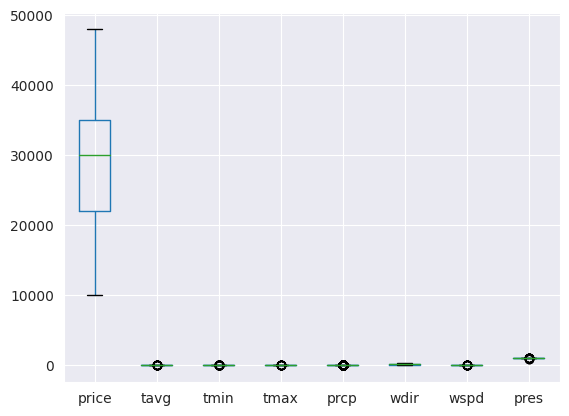

In [7]:
df.boxplot()

In [8]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df[(df['price'] < lower_bound) | (df['price'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df.at[df.index[0], 'price'] = min(max(df.iloc[0]['price'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df.index[previous_date_index]
        previous_value = df.loc[previous_date, 'price']
        df.at[index, 'price'] = previous_value

Số lượng outlier: 0


<Axes: >

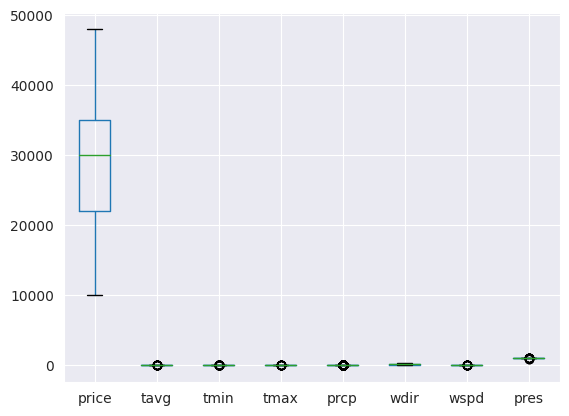

In [9]:
df.boxplot()

In [10]:
df = df.dropna()

In [11]:
df_corr = df.copy()
df_corr.tavg = df_corr.tavg.shift(-30)
df_corr.pres = df_corr.pres.shift(60)



In [12]:
# Find the pearson correlations matrix
corr = df_corr.corr(method = 'pearson')
corr

,price,tavg,tmin,tmax,prcp,wdir,wspd,pres
price,1.000000,0.032149,-0.068197,-0.040019,-0.052391,-0.000095,0.133150,-0.202982
tavg,0.032149,1.000000,-0.041542,0.136281,-0.118702,-0.175824,0.087418,-0.045956
tmin,-0.068197,-0.041542,1.000000,0.468589,0.007997,0.051379,0.338232,0.258924
tmax,-0.040019,0.136281,0.468589,1.000000,-0.165993,-0.183095,0.122516,0.215593
prcp,-0.052391,-0.118702,0.007997,-0.165993,1.000000,0.160484,0.007117,0.004274
wdir,-0.000095,-0.175824,0.051379,-0.183095,0.160484,1.000000,0.108276,0.095916
wspd,0.133150,0.087418,0.338232,0.122516,0.007117,0.108276,1.000000,0.098566
pres,-0.202982,-0.045956,0.258924,0.215593,0.004274,0.095916,0.098566,1.000000


In [13]:
fillter_feature = ['price', 'tavg', 'pres',  'prcp']
df = df[fillter_feature]

In [14]:
# Find the pearson correlations matrix
corr = df.corr(method = 'pearson')
corr

,price,tavg,pres,prcp
price,1.000000,-0.059021,0.009254,-0.052391
tavg,-0.059021,1.000000,-0.030529,-0.126228
pres,0.009254,-0.030529,1.000000,-0.129443
prcp,-0.052391,-0.126228,-0.129443,1.000000


<Axes: xlabel='date'>

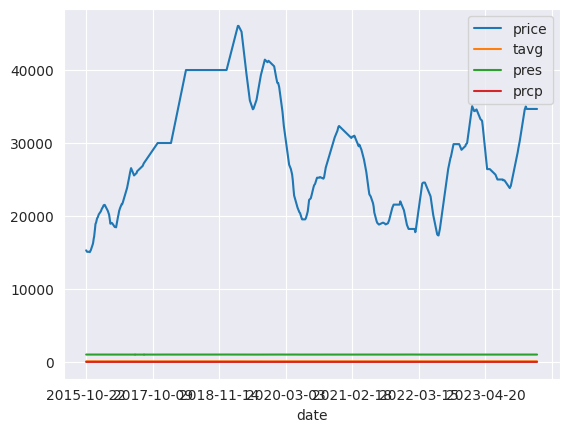

In [15]:
df.price = df.price.rolling(45).mean()
df = df.dropna()
df.plot()

In [16]:
nobs = int(len(df) * 0.8)
df_train, df_test = df[0:nobs], df[nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(1084, 4)
(272, 4)


In [17]:
from google.colab import files


## Kiểm tra stationary

In [18]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [19]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6753
 No. Lags Chosen       = 3
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0784. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.5377
 No. Lags Chosen       = 8
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Sig

In [20]:
# df_differenced = np.log(df_train)
# df_differenced = df_differenced.dropna()
# df_differenced = df_differenced[1:]

In [21]:
df_differenced = df_train.diff().dropna()

In [22]:
df_differenced

,price,tavg,pres,prcp
date,,,,
2015-10-29,-66.666667,3.4,1.1,0.000
2015-11-05,-66.666667,-5.6,-1.7,0.000
2015-11-12,-66.666667,3.6,0.9,0.000
2015-11-20,0.000000,1.7,-2.2,0.000
2015-11-26,0.000000,-2.6,3.1,0.000
...,...,...,...,...
2022-08-24,333.333333,-1.3,-0.8,-0.060
2022-09-07,333.333333,-3.6,2.2,0.237
2022-09-08,333.333333,2.0,1.5,0.141


In [23]:
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.7371
 No. Lags Chosen       = 2
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0001. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "tavg" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.98
 No. Lags Chosen       = 12
 Critical value 1%     = -3.436
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "pres" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0

<Axes: xlabel='date'>

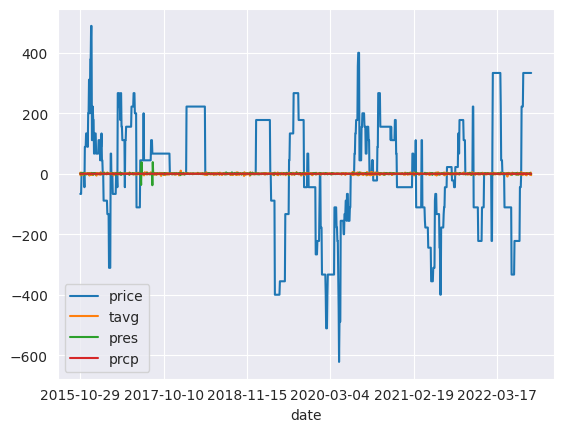

In [24]:
df_differenced.plot()

## Train model

Chúng tôi sử dụng phương pháp điều chỉnh tham số bằng cách lặp qua các bộ tham số tương tứng (p, d, q) cho ARIMA, kết hợp biến ngoại sinh (exogenous) cho mô hình ARIMAX, (p) cho mô hình VAR và (p, q) cho mô hình VARMA.  

Chọn tham số (p, q) cho mô hình VARMA còn là sự kết hợp với mô hình ARIMA để tìm được bộ tham số tốt nhất cho tập dữ liệu giá. Sau đó áp dụng vào mô hình với dữ liệu đa biến để tăng tốc độ và đảm bảo mô hình có độ chính xác cao.  

Việc chọn tham số cần kết hợp với các đồ thị tự tương quan ACF và PACF để chọn đầu vào tối ưu. 

In [25]:
from statsmodels.tsa.stattools import acf
from sklearn.metrics import mean_absolute_percentage_error
def forecast_accuracy(forecast, actual):
    mape = mean_absolute_percentage_error(actual, forecast) * 100 # MAPE

    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return({'mape':mape,'rmse':rmse})

In [26]:
columns_train = fillter_feature

In [27]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 11.4 MB/s eta 0:00:00


In [28]:
from pmdarima import auto_arima

In [29]:
arimax = auto_arima(df_differenced.price, exogenous = df_differenced[[ 'tavg', 'pres',  'prcp']],
           start_p=3,
           start_q=3,
           max_p=7,
           max_q=7,
                    n_jobs=10,
            max_order=20,
            seasonal=False,
          trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=10.86 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11699.028, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11701.021, Time=0.28 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11701.019, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11697.079, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=5.36 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 17.980 seconds


In [30]:
def inverse_diff(actual_df, pred_df):
    df_res = pred_df.copy()
    columns = actual_df.columns
    for col in columns:
        df_res[str(col)+'_forecast'] = actual_df[col].iloc[-1] + df_res[str(col)].cumsum()
    return df_res

In [31]:
# Forecast
n_periods = len(df_test)
fitted, confint = arimax.predict(n_periods=n_periods,
                                  exogenous=[ 'tavg', 'pres',  'prcp'],
                                  return_conf_int=True)


In [32]:
np.square(fitted)

1083    111111.111111
1084    111111.111111
1085    111111.111111
1086    111111.111111
1087    111111.111111
            ...      
1350    111111.111111
1351    111111.111111
1352    111111.111111
1353    111111.111111
1354    111111.111111
Length: 272, dtype: float64

In [33]:
df_test.index

Index(['2022-09-13', '2022-09-14', '2022-09-16', '2022-09-19', '2022-09-20',
       '2022-09-21', '2022-09-22', '2022-09-23', '2022-09-26', '2022-09-27',
       ...
       '2024-01-23', '2024-01-24', '2024-02-19', '2024-02-20', '2024-02-26',
       '2024-02-28', '2024-02-29', '2024-03-04', '2024-03-05', '2024-03-06'],
      dtype='object', name='date', length=272)

In [34]:
fc_series = pd.DataFrame({'price': fitted.values}, index = df_test.index)

In [35]:
fc_series

,price
date,
2022-09-13,333.333333
2022-09-14,333.333333
2022-09-16,333.333333
2022-09-19,333.333333
2022-09-20,333.333333
...,...
2024-02-28,333.333333
2024-02-29,333.333333
2024-03-04,333.333333


In [37]:
fc_series.price = df_test.price.iloc[0] + fc_series.price.cumsum()

Đánh giá mô hình

In [39]:
accuracy_prod = forecast_accuracy(fc_series['price'].values, df_test['price'].values)
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))

mape :  141.8819
rmse :  48630.8613


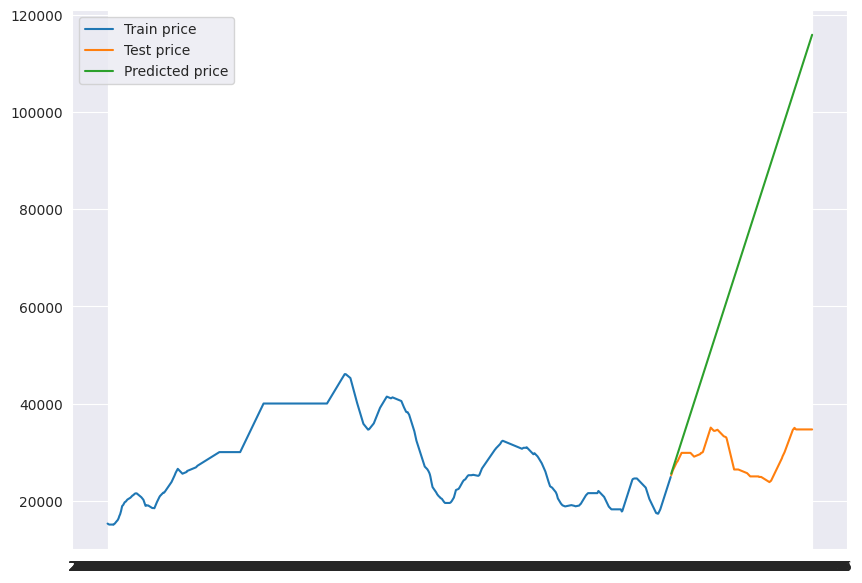

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline
for i in ['price']:

    plt.rcParams["figure.figsize"] = [10,7]
    plt.plot(df_train[str(i)], label='Train '+str(i))
    plt.plot(df_test[str(i)], label='Test '+str(i))
    plt.plot(fc_series[str(i)], label='Predicted '+str(i))
    plt.legend(loc='best')
    plt.show()

Để kiểm tra hiệu suất mô hình đã xây dựng, chúng tôi đánh giá hiệu suất trên tập huấn luyện và kiểm tra với việc tính sai số rmse và mape. 

Sau khi hoàn thành huấn luyện và đánh giá hiệu suất mô hình, chúng tôi tinh chỉnh các tham số, huấn luyện lại mô hình nhiều lần để tìm ra mô hình với bộ tham số thật tối ưu. 

In [44]:
import joblib
from google.colab import drive

file_name = "arimax_gia_xoai_thoi_tiet.joblib"
drive.mount('/content/drive')

joblib.dump(arimax, '/content/drive/MyDrive/model/' + file_name)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['/content/drive/MyDrive/model/arimax_gia_xoai_thoi_tiet.joblib']